# 5、高维异常探测

## **1、高维异常探测存在问题**
在实际场景中，很多数据集都是多维度的。随着维度的增加，数据空间的大小（体积）会以指数级别增长，使数据变得稀疏，这便是维度诅咒的难题。

## **2、解决方法**
**集成**是子空间思想中常用的方法之一，可以有效提高数据挖掘算法精度。集成方法将多个算法或多个基检测器的输出结合起来。其基本思想是一些算法在某些子集上表现很好，一些算法在其他子集上表现很好，然后集成起来使得输出更加鲁棒。在无监督学习时，提高模型的鲁棒性很重要，因此集成学习就大有用武之地。

### 2.1 Feature Bagging

最早的集成检测框架feature bagging与分类问题中的随机森林（random forest）很像，先将训练数据随机划分（每次选取所有样本的d/2-d个特征，d代表特征数），得到多个子训练集，再在每个训练集上训练一个独立的模型（默认为LOF）并最终合并所有的模型结果（如通过平均）。值得注意的是，因为没有标签，异常检测往往是通过bagging和feature bagging比较多，而boosting比较少见。boosting情况下的异常检测，一般需要生成伪标签。

以下实现的是feature bagging基于pyod的代码

D:\program\Anaconda\Lib\site-packages\pyod\utils\data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)



On Training Data:
FeatureBagging ROC:1.0, precision @ rank n:1.0

On Test Data:
FeatureBagging ROC:1.0, precision @ rank n:1.0


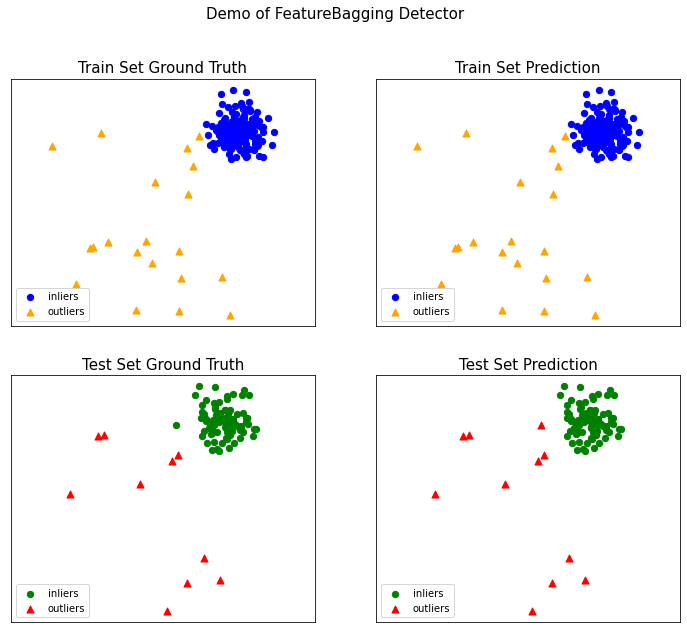

In [1]:
# -*- coding: utf-8 -*-
"""Example of using Feature Bagging for outlier detection
"""
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.feature_bagging import FeatureBagging
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train Feature Bagging detector
    clf_name = 'FeatureBagging'
    clf = FeatureBagging(check_estimator=False)
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)


接下来针对feature bagging 加入我们的对比实验，对比实验基于sklearn进行展开。

In [2]:
# test classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=5)
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


In [3]:
# evaluate bagging algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=5)
# define the model
model = BaggingClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.855 (0.035)


首先，将Bagging集合适合所有可用数据，然后可以调用Forecast（）函数对新数据进行预测。
下面的示例在我们的二进制分类数据集中展示了这一点。

In [4]:
# make predictions using bagging for classification
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=5)
# define the model
model = BaggingClassifier()
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
row = [[-4.7705504,-1.88685058,-0.96057964,2.53850317,-6.5843005,3.45711663,-7.46225013,2.01338213,-0.45086384,-1.89314931,-2.90675203,-0.21214568,-0.9623956,3.93862591,0.06276375,0.33964269,4.0835676,1.31423977,-2.17983117,3.1047287]]
yhat = model.predict(row)
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1


### 2.2 随机森林random forest

随机森林就是通过集成学习的思想将多棵树集成的一种算法，它的基本单元是决策树，而它的本质属于机器学习的一大分支——集成学习（Ensemble Learning）方法。随机森林的名称中有两个关键词，一个是“随机”，一个就是“森林”。“森林”我们很好理解，一棵叫做树，那么成百上千棵就可以叫做森林了，这样的比喻还是很贴切的，其实这也是随机森林的主要思想--集成思想的体现。
其实从直观角度来解释，每棵决策树都是一个分类器（假设现在针对的是分类问题），那么对于一个输入样本，N棵树会有N个分类结果。而随机森林集成了所有的分类投票结果，将投票次数最多的类别指定为最终的输出，这就是一种最简单的 Bagging 思想。
这两种随机性来源的目的是降低森林估计器的方差。事实上，单个决策树通常表现出高方差，并且倾向于过度拟合。森林中的注入随机性使得决策树具有一定程度的解耦预测误差。通过取这些预测的平均值，一些错误可以抵消。随机森林通过组合不同的树来减少方差，有时以稍微增加偏差为代价。在实践中，方差的减少通常是显著的，因此产生了一个整体上更好的模型。

**实现步骤：**
1 N个样本用来训练一个决策树，作为决策树根节点处的样本。
2 当每个样本有M个属性时，在决策树的每个节点需要分裂时，随机从这M个属性中选取出m个属性，满足条件m << M。然后从这m个属性中采用某种策略（比如说信息增益）来选择1个属性作为该节点的分裂属性。
3 决策树形成过程中每个节点都要按照步骤2来分裂（很容易理解，如果下一次该节点选出来的那一个属性是刚刚其父节点分裂时用过的属性，则该节点已经达到了叶子节点，无须继续分裂了）。一直到不能够再分裂为止。注意整个决策树形成过程中没有进行剪枝。
4 按照步骤1~3建立大量的决策树，这样就构成了随机森林了。

**优点**
它可以出来很高维度（特征很多）的数据，并且不用降维，无需做特征选择
它可以判断特征的重要程度
可以判断出不同特征之间的相互影响
不容易过拟合
训练速度比较快，容易做成并行方法
实现起来比较简单
对于不平衡的数据集来说，它可以平衡误差。
如果有很大一部分的特征遗失，仍可以维持准确度。

**缺点**
随机森林已经被证明在某些噪音较大的分类或回归问题上会过拟合。
对于有不同取值的属性的数据，取值划分较多的属性会对随机森林产生更大的影响，所以随机森林在这种数据上产出的属性权值是不可信的

参考连接：https://easyai.tech/ai-definition/random-forest/#waht

以下是随机森林基于pyod的代码实现：

D:\program\Anaconda\Lib\site-packages\pyod\utils\data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)



On Training Data:
IForest ROC:0.9972, precision @ rank n:0.9

On Test Data:
IForest ROC:1.0, precision @ rank n:1.0


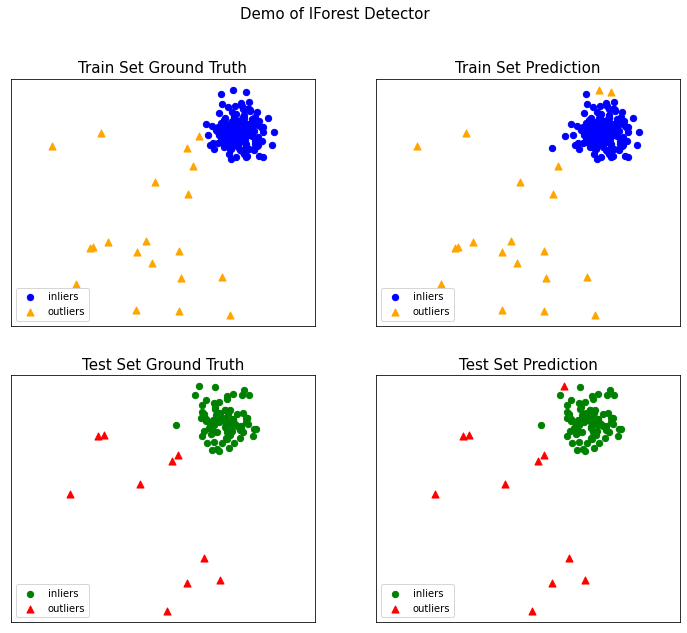

In [5]:
# -*- coding: utf-8 -*-
"""Example of using Isolation Forest for outlier detection
"""
# Author: Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause

from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train IForest detector
    clf_name = 'IForest'
    clf = IForest()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)


基于其他库对于随机森林做实现，这类选取的数据是鸢尾花数据集。

In [7]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

train, test = df[df['is_train'] == True], df[df['is_train'] == False]

features = df.columns[:4]
clf = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['species'])
clf.fit(train[features], y)

preds = iris.target_names[clf.predict(test[features])]
pd.crosstab(test['species'], preds, rownames=['actual'], colnames=['preds'])

preds,setosa,versicolor,virginica
actual,,,
setosa,9,0,0
versicolor,0,16,0
virginica,0,1,7


与其他的机器学习算法对比

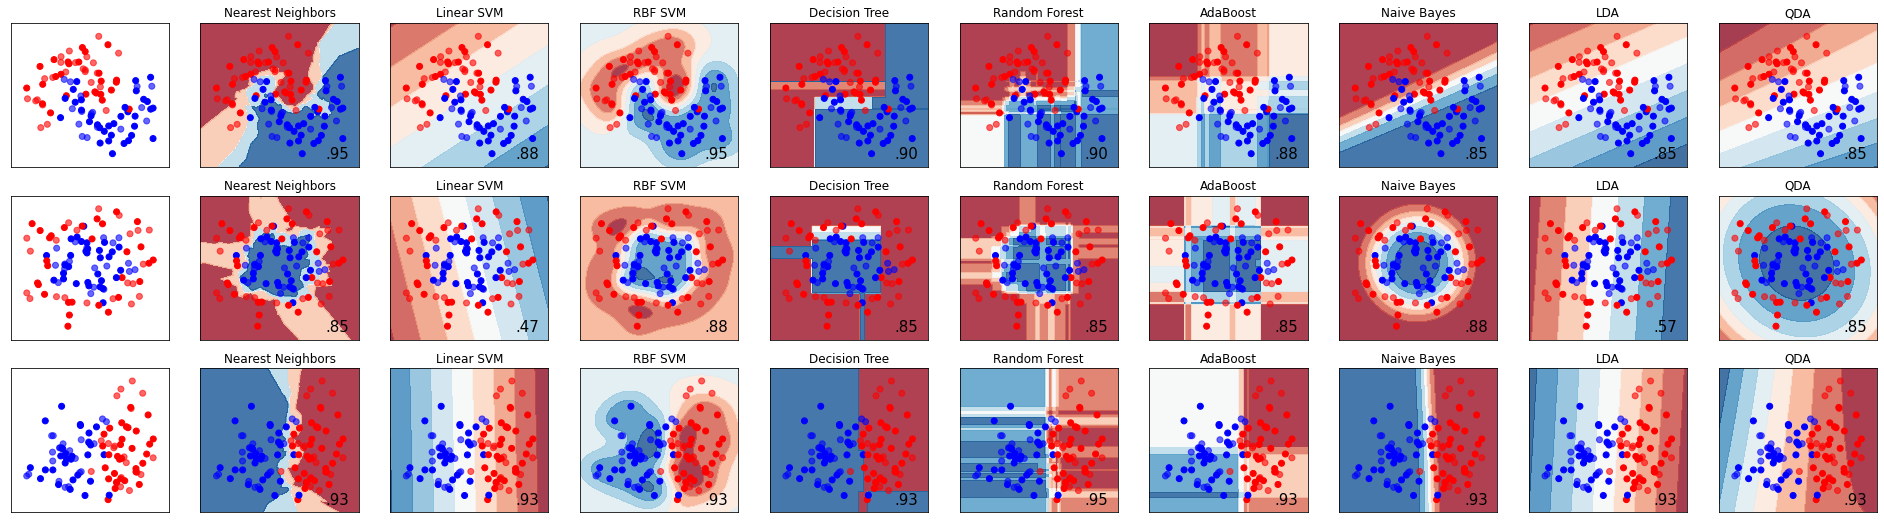

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "LDA", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LDA(),
    QDA()]
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
figure.subplots_adjust(left=.02, right=.98)
plt.show()


这里随机生成了三个样本集，分割面近似为月形、圆形和线形的。我们可以重点对比一下决策树和随机森林对样本空间的分割：
　　1）从准确率上可以看出，随机森林在这三个测试集上都要优于单棵决策树，90%>85%，82%>80%，95%=95%；
　　2）从特征空间上直观地可以看出，随机森林比决策树拥有更强的分割能力（非线性拟合能力）。

### 思考题1：feature bagging为什么可以降低方差？
bagging通过在不同数据集上训练模型降低分类器的方差。换句话说，bagging可以预防过拟合。
bagging的有效性来自不同训练数据集上单独模型的不同，它们的误差在投票过程中相互抵消。此外，某些bootstrap训练样本很可能略去离散值。
模型的期望泛化误差由偏差和方差组成。一般来说，简单模型偏差高，方差低；复杂模型方差高，偏差低。
通常降低方差的方法之一是将多个模型平均起来。
这样模型均值的方差仅为单模型方差的 1/n 。然而在只有一个数据集的情况下只能训练出一个模型，也就没法求平均。所以为了缓解这个问题，可以采用有放回抽样来模拟生成多个数据集，将每个数据集训练得到的模型平均来降低方差，即是Bagging的基本思想。
参考连接：https://zhuanlan.zhihu.com/p/36822575

### 思考题2：feature bagging存在哪些缺陷，有什么可以优化的idea？
同样是弱分类器组合的思路，相对于Boosting，其实Bagging更好理解。它首先随机地抽取训练集（training set），以之为基础训练多个弱分类器。然后通过取平均，或者投票(voting)的方式决定最终的分类结果。
因为它随机选取训练集的特点，Bagging可以一定程度上避免过渡拟合(overfit)。最强的Bagging算法是基于SVM的。如果用定义不那么严格的话，随机森林也算是Bagging的一种。
**使用情景：**
相较于经典的必使算法，Bagging使用的人更少一些。一部分的原因是Bagging的效果和参数的选择关系比较大，用默认参数往往没有很好的效果。
虽然调对参数结果会比决策树和LR好，但是模型也变得复杂了。
**关于改进：**
AdaBoosting算法
针对上述Boosting存在的缺陷和问题，Freund和Schapire根据在线分配算法理论提出了AdaBoost算法，是一种改进的Boosting分类算法。AdaBoost分类算法是一种自适应提升的方法，由于训练的过程是重复使用相同的训练集，因而不要求数据集很大，其自身就可以组合任意数量的基分类器。在AdaBoost算法中，尽管不同的基分类器使用的训练集稍有差异，但这种差异是随机选择造成的，所不同的是，这种差异是前一个基分类器的误差函数。而提升的过程是针对一个特定问题的实际性能，显然这就依赖于具体的数据和单个基分类器的性能。因此，训练的过程需要有充足的训练数据，并且基分类器应当是弱的但又不至于太弱(即分类准确率略大于50％)，而提升的过程对噪声和离群点的干扰尤为明显。
(1)提高那些被前几轮弱分类器线性组成的分类器错误分类的的样本的权值，这样做能够将每次训练的焦点集中在比较难分的训练样本上；
(2)将弱分类器有机地集成起来，使用加权投票机制代替平均投票机制，从而使识别准确率较高的弱分类器具有较大的权重，使其在表决中起较大的作用，相反，识别准确率较低的分类器具有较小的权重，使其在表决中起较小的作用。
与Boosting分类算法相比，AdaBoost算法不需要预先获得弱分类算法识别准确率的下限(弱分类器的误差)，只需关注于所有弱分类算法的分类精度(分类准确率略大于50％)。

*参考资料：*
Ensemble methods. Bagging and Boosting
Bagging, boosting and stacking in machine learning